# Cartpole with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_data = 10000
batch_size = 512
portion = 1

learning_rate = 3e-4
min_delta = 0
patience = 20

time_horizon = 3
solver = 'rk4'

model_name = 'CartpoleC_LNNODE.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Create the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import CartPoleCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = CartPoleCustomEnv()
low = np.array([-8])
high = -low

dataModule = Gym_DataModule_rng(env,
                                num_data,
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                # data_dir='../../data/dataset'
                                )
dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [q, dq])

torch.Size([10000, 3, 5])
torch.Size([10000, 3, 1])
torch.Size([10000, 3, 1])
torch.Size([10000, 3, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module import LNNODE, LNN
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([3, 512, 512, 512, 2], activation='tanh')
potentialNet = MLP([3, 512, 512, 512, 1], activation='tanh')
controlNet = MatrixNet([3, 64, 64, 2], control_dim=1, activation='relu')

lagFunc = LNNODE(num_angle=1, 
                 massMatrixNet=massMatrixNet,
                 potentialNet=potentialNet,
                 # controlNet=controlNet
                 )

# lagFunc = LNN(num_angle=1, 
#                  massMatrixNet=massMatrixNet,
#                  potentialNet=potentialNet,
#                  # controlNet=controlNet
#                  )

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

### Pretrain with time horizon = 2

In [9]:
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [10]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 3

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :self.time_horizon, 0]
        q_dq_u = torch.cat([x, u], dim=2)

        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u[:, :self.time_horizon, :], est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [11]:
# pre_Learn = Pre_learner(lagODE)
# pre_trainer = pl.Trainer(max_epochs=10)
# pre_trainer.fit(pre_Learn, dataModule)

### Define Pytorch lightning trainer

In [12]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, infos = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x, u], dim=2)
        
        bs, time, xdim = x.shape
        _, _, cdim = u.shape
        # dx = (x[:, 1:, :] - x[:, :-1, :]) / (t[:, 1:, :] - t[:, :-1, :])
        dx = infos.reshape(-1, 2)
        est_grad = self.model.defunc(0, x[:, :, :].reshape(-1, xdim))
        loss = self.loss_func(est_grad[:, 3:], dx)
        
        # est = self.model.trajectory(q_dq_u[:, 0, :], t_span)
        # loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, u, t, infos = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x, u], dim=2)
        
        bs, time, xdim = x.shape
        _, _, cdim = u.shape
        dx = infos.reshape(-1, 2)
        est_grad = self.model.defunc(0, x[:, :, :].reshape(-1, xdim))
        loss = self.loss_func(est_grad[:, 3:], dx)
        
        # est = self.model.trajectory(q_dq_u[:, 0, :], t_span)
        # loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [13]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 1.1 M 
------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.225     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 223.423
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 125.163 >= min_delta = 0. New best score: 98.260


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 16.856 >= min_delta = 0. New best score: 81.404


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 16.860 >= min_delta = 0. New best score: 64.544


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 13.467 >= min_delta = 0. New best score: 51.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 15.119 >= min_delta = 0. New best score: 35.959


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 7.031 >= min_delta = 0. New best score: 28.928


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.670 >= min_delta = 0. New best score: 24.258


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.037 >= min_delta = 0. New best score: 21.221


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.129 >= min_delta = 0. New best score: 19.092


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.720 >= min_delta = 0. New best score: 17.372


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.486 >= min_delta = 0. New best score: 15.886


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.295 >= min_delta = 0. New best score: 14.590


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.136 >= min_delta = 0. New best score: 13.455


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.009 >= min_delta = 0. New best score: 12.446


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.886 >= min_delta = 0. New best score: 11.559


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.824 >= min_delta = 0. New best score: 10.736


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.743 >= min_delta = 0. New best score: 9.993


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.681 >= min_delta = 0. New best score: 9.312


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.626 >= min_delta = 0. New best score: 8.685


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.576 >= min_delta = 0. New best score: 8.110


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.528 >= min_delta = 0. New best score: 7.582


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.486 >= min_delta = 0. New best score: 7.096


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.458 >= min_delta = 0. New best score: 6.638


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.420 >= min_delta = 0. New best score: 6.218


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.387 >= min_delta = 0. New best score: 5.831


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.353 >= min_delta = 0. New best score: 5.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.330 >= min_delta = 0. New best score: 5.148


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.345 >= min_delta = 0. New best score: 4.804


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.311 >= min_delta = 0. New best score: 4.493


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.463 >= min_delta = 0. New best score: 4.029


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.857 >= min_delta = 0. New best score: 3.173


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.397 >= min_delta = 0. New best score: 1.776


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.806 >= min_delta = 0. New best score: 0.970


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.218 >= min_delta = 0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.128 >= min_delta = 0. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0. New best score: 0.574


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0. New best score: 0.536


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0. New best score: 0.515


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0. New best score: 0.500


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.494


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0. New best score: 0.469


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.467


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0. New best score: 0.442


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0. New best score: 0.425


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0. New best score: 0.414


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0. New best score: 0.391


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.389


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0. New best score: 0.376


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 0.368


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.363


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 0.355


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.355


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 0.348


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 0.341


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.339


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.337


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 0.327


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.322


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.322


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.320


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.314


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0. New best score: 0.311


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0. New best score: 0.309


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.306


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 0.297


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0. New best score: 0.265


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0. New best score: 0.242


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0. New best score: 0.220


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.214


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.209


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.209


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0. New best score: 0.194


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.194


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.190


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.184


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.182


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 0.173


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.171


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [15]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [17]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [18]:
# define testing time stamp
env = CartPoleCustomEnv()
dt = env.dt
full = 300
t_span = torch.linspace(dt, dt*full, full)

In [19]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = CartPoleCustomEnv()
obs = []
infos = []

split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
controls = np.zeros_like(controls)

# x, dx, th, dth
init = np.array([0., 0., np.pi / 8, 0.])

obs0, _ = env.reset(init)

prev_obs = obs0
for i in range(full):
    obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(controls[i])
    infos.append(np.array([info['ddx'], info['ddth']]))
    prev_obs = next_obs
                 
obs = torch.tensor(obs)
infos = torch.tensor(infos)
controls = torch.Tensor(controls).view(-1, 1)

### Generate prediction

In [20]:
import torch
import torch.nn as nn

from scipy.integrate import solve_ivp


def traj_pred(dt, model: nn.Module, y0: torch.Tensor, controls: torch.Tensor):
    """
    Generate one trajectory. Since we have a fixed control here, We need to solve the ivp independently
    :param dt: Sampling interval, should be equal to the env
    :param model: Our Model of the ODE
    :param y0: initial condition
    :param controls: control
    :return: None
    """
    num_steps, control_dim = controls.shape

    t_eval = torch.linspace(0, dt * (num_steps-1), num_steps)

    def dummy(t, y):
        # y should be in [r, cos q, sin q, dr, dq] form
        # piecewise constant control, same for Gym. Interesting to see the behaviour in real env.
        # open loop design
        idx = int(torch.tensor(t) / dt)
#         y_u = torch.cat([torch.tensor(y), controls[idx]]).float()
        y_u = torch.cat([torch.tensor(y),]).float()
        grad = model.defunc(0, y_u.view(1, -1))
        grad = grad.detach().numpy()[0, :]
        return grad

    sol = solve_ivp(dummy, [0., dt * (num_steps-1)], y0, method='RK45', t_eval=t_eval)
    return sol

In [26]:
# from utils import traj_pred
dt = env.dt
q_dq_u = torch.cat([obs, controls], dim=1)
est_grad = test_model.defunc(0, obs.float())
est = traj_pred(dt, test_model, obs0, controls)

In [22]:
obs0 = torch.tensor(obs0).detach()
th0 = torch.atan(torch.tensor(obs0[2]/obs0[1]))
x0 = torch.tensor([obs0[0], obs0[3], th0, obs0[4]]).detach().numpy()

<ipython-input-22-dbf8feecef82>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  th0 = torch.atan(torch.tensor(obs0[2]/obs0[1]))


In [23]:
from scipy.integrate import solve_ivp
from gym_env import CartPoleCustomEnv
env = CartPoleCustomEnv()

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    u = controls[idx-1]
    
    grad = env.dynamics(t, y, u)
    
    return grad


sol = solve_ivp(dummy, [dt, dt*full], x0, method='LSODA', t_eval=t_span.detach().numpy())

### Check gradient

No handles with labels found to put in legend.
No handles with labels found to put in legend.


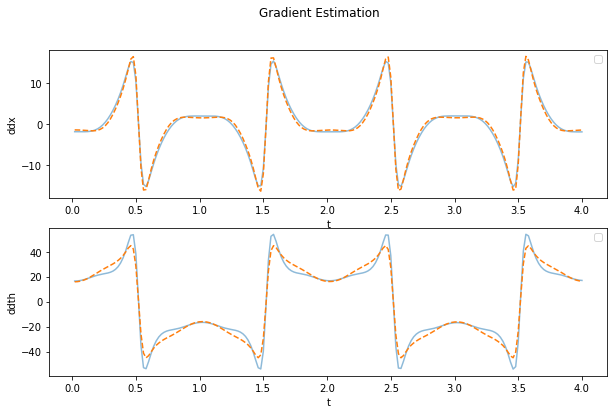

In [24]:
length = 200

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(133)

# Check ddx
ax1.plot(t_span.detach().numpy()[:length], infos[:length, 0], alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[:length], est_grad[:length, 3].detach().numpy(), '--')  # LNN

# check ddth
ax2.plot(t_span.detach().numpy()[:length], infos[:length, 1], alpha=0.5)
ax2.plot(t_span.detach().numpy()[:length], est_grad[:length, 4].detach().numpy(), '--')  # LNN

ax1.legend(); ax2.legend()
ax1.set_xlabel("t"); ax2.set_xlabel("t")
ax1.set_ylabel("ddx"); ax2.set_ylabel("ddth")
fig.suptitle("Gradient Estimation")

None

### Check trajectory

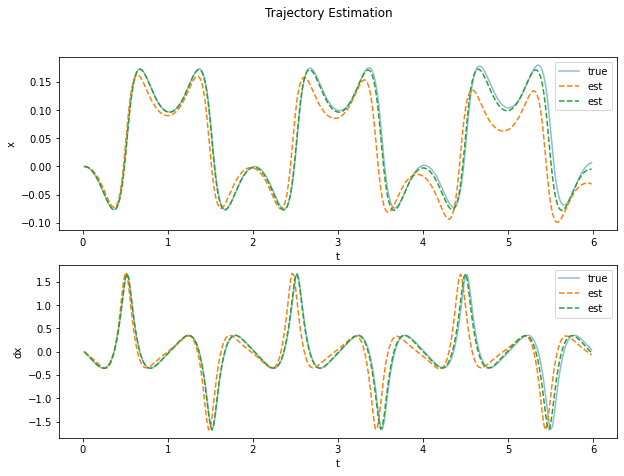

In [28]:
# Check trajectory
length = 299

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot x
ax1.plot(t_span.detach().numpy()[:length], obs[:length, 0].detach().numpy(), alpha=0.5, label='true')
ax1.plot(t_span.detach().numpy()[:length], est.y[0, :length], '--', label='est')
ax1.plot(t_span.detach().numpy()[:length], sol.y[0, :length], '--', label='est')

# Plot dx
ax2.plot(t_span.detach().numpy()[:length], obs[:length, 3].detach().numpy(), alpha=0.5, label='true')
ax2.plot(t_span.detach().numpy()[:length], est.y[3, :length], '--', label='est')
ax2.plot(t_span.detach().numpy()[:length], sol.y[1, :length], '--', label='est')

ax1.legend(); ax2.legend()
ax1.set_xlabel("t"); ax2.set_xlabel("t")
ax1.set_ylabel("x"); ax2.set_ylabel("dx")
fig.suptitle("Trajectory Estimation")
None

In [ ]:
# Check trajectory
length = 300

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos th
ax1.plot(t_span.detach().numpy()[:length], obs[:length, 1].detach().numpy(), alpha=0.5, label='true')
ax1.plot(t_span.detach().numpy()[:length], est.y[1, :length], '--', label='est')
ax1.plot(t_span.detach().numpy()[:length], np.cos(sol.y[2, :length]), '--', label='est')

# Plot sin th
ax2.plot(t_span.detach().numpy()[:length], obs[:length, 2].detach().numpy(), alpha=0.5, label='true')
ax2.plot(t_span.detach().numpy()[:length], est.y[2, :length], '--', label='est')
ax2.plot(t_span.detach().numpy()[:length], np.sin(sol.y[2, :length]), '--', label='est')

# Plot dth
ax3.plot(t_span.detach().numpy()[:length], obs[:length, 4].detach().numpy(), alpha=0.5, label='true')
ax3.plot(t_span.detach().numpy()[:length], est.y[4, :length], '--', label='est')
ax3.plot(t_span.detach().numpy()[:length], sol.y[3, :length], '--', label='est')

ax1.legend(); ax2.legend(); ax3.legend()
ax1.set_xlabel("t"); ax2.set_xlabel("t"); ax3.set_xlabel("t")
ax1.set_ylabel("x"); ax2.set_ylabel("cos th"); ax3.set_ylabel("sin th")
fig.suptitle("Trajectory Estimation")
None

### Plot Phase Space Trajectory

In [ ]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(est[:length, 0, 1] / est[:length, 0, 0])
est_thdot = est[:length, 0, 2]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th.detach().numpy(), est_thdot.detach().numpy())

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    M_est[i] = test_model.defunc.m.massMatrixNet(x[i].view(1, 1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)


V_est = torch.zeros(x.shape)

for i in range(n_grid):
    V_est[i] = test_model.defunc.m.potentialNet(x[i].view(1, 1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

## Conclusion

- Everythings good
    - Check if learning x instead is better